> ### EEE4423: Deep Learning Lab

# LAB \#11: Character Generation using LSTM

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-19 10:55:27.180756


In [2]:
%pip install unidecode

You should consider upgrading via the '/home/jovyan/.venv/torch1.9.0-py3.8-cuda11.1/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import unidecode
import string
import random
import re
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

These sorts of generative models form the basis of machine translation, image captioning, question answering and more.

<img src="http://drive.google.com/uc?export=view&id=16E7HG_dCyfTo9u9qrrhp2eClq6xK6-f_" style="width: 600px;"/>

### 1. Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package

<img src="http://drive.google.com/uc?export=view&id=171lX3vxj60AQNScQi872BHx2Rz6J7-3J" />

In [4]:
file = unidecode.unidecode(open('../dataset/lab11/lose_yourself_eminem.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4063


To make inputs out of this big string of data, we will be splitting it into chunks.

In [5]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

 its gaping
This world is mine for the taking
Make me king, as we move toward a, new world order
A normal life is borin', but super stardom's close to post mortar
It only grows harder, only grows hotte


Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [6]:
# Turn string into list of longs
all_characters = string.printable
print(all_characters)

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print('abcDEF is changed to ', char_tensor('abcDEF'))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



abcDEF is changed to  tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [7]:
def random_training_set():    
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

### 2. Build the LSTM model [4 points]

#### [Diagram of LSTM]
<img src="http://drive.google.com/uc?export=view&id=1baQ6Ffu-vDcXbOEBYGeLzhmfvaj4DGgW" style="width: 800px;"/>
LSTM consists of cell state, hidden state and 3 gates that modify or use the cell state. The cell state is the key part of the LSTM and you can think that information "flows" in there. The operation of 3 gates are described in below.

#### [Forget Gate]
<img src="http://drive.google.com/uc?export=view&id=1sJisl5P0hggmvH4qrcYgSETFKdFdBSH_" style="width: 600px;"/>
The forget gate determines which information in the cell state should be erased.

#### [Input Gate]
First, the candidate cell state is created using the current input and the previous hidden state. And the input gate determines how much the candidate cell state is reflected to the cell state.
<img src="http://drive.google.com/uc?export=view&id=1Df-k5FORGH7PnXauYcb8qqUpY3Uot9A7" style="width: 600px;"/>

#### [Output Gate]
<img src="http://drive.google.com/uc?export=view&id=1JLCGPcrZLOYfjyJhMTvmfixHq5plFj8L" style="width: 600px;"/>
The output gate determines which elements should be extracted from the cell state to produce the output.

<img src="http://drive.google.com/uc?export=view&id=1kGq8DwwzizuNcg6GF0GaP1DAu26FFlrB" style="width: 300px;"/>
The above expression is summarized as follows,


This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one LSTM layer that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [8]:


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim 
        self.output_dim = output_dim
        
        self.encoder = nn.Embedding(input_dim, hidden_dim) # input_dim(세로) * hidden_dim(까로)의 구조가됨.  
        
        # lstm
        # The size of input is (batch_size, seq_dim, hidden_dim)
        #############
        self.w_x = nn.Linear(hidden_dim, 4*hidden_dim, bias=True)
        self.w_h = nn.Linear(hidden_dim, 4*hidden_dim, bias=True)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        #############
        
        self.decoder = nn.Linear(hidden_dim, output_dim)
        
        
    
    def forward(self, input, hn, cn):
        #############
        input = input.unsqueeze(0).unsqueeze(0)
        input = self.encoder(input)
        
        gates = self.w_x(input) + self.w_h(hn)
        # i, f, o, g = gates.chunk(4, dim=2)
        gates = gates.squeeze()
        i, f, o, g = gates.chunk(4)
        i = i.unsqueeze(0).unsqueeze(0)
        f = f.unsqueeze(0).unsqueeze(0)
        o = o.unsqueeze(0).unsqueeze(0)
        g = g.unsqueeze(0).unsqueeze(0)
        
        i = self.sigmoid(i)
        f = self.sigmoid(f)
        o = self.sigmoid(o)
        g = self.tanh(g)
         
        cn = cn*f + i*g
        hn = o*self.tanh(cn)
        out = self.decoder(hn)
        #############
        return out, hn, cn

    def init_hidden(self):
        # The size of h0, c0 should be (layer_dim, batch_size, hidden_dim)
        #############
        h0 = torch.zeros(self.layer_dim,1,self.hidden_dim).cuda()    
        c0 = torch.zeros(self.layer_dim,1,self.hidden_dim).cuda()
        #############
        return h0, c0
    
hidden_dim = 100
n_layers = 1
n_characters = len(all_characters) #100

model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters)
model.cuda()

LSTMModel(
  (encoder): Embedding(100, 100)
  (w_x): Linear(in_features=100, out_features=400, bias=True)
  (w_h): Linear(in_features=100, out_features=400, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

### 3. Loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()

lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 4 . Write the character level generation code [4 points]

- Generate a sentence with a length of $predict\_len$, starting from a single character $prime\_str$.
- Example) evaluate(prime_str='Y', predict_len=20) -> You better let it go

In [10]:
def evaluate(prime_str = 'W', predict_len = 100):
    # suppose prime_str is a single character
    # and use greedy search to predict the next character

    hn, cn = model.init_hidden()
    predicted = str()
    x = char_tensor(prime_str).cuda()
    print(prime_str, end="")
    for i in range(predict_len):
        #############
        output, hn, cn = model(x, hn, cn)
        output = output.data.view(-1).exp()    # to positive number
        _, top_i = torch.topk(output, 1)

        predicted = all_characters[top_i[0]]
        print(predicted, end="")
        x = char_tensor(predicted).cuda()
        #############

    return predicted

### 5 . Write the code to train the model [2 points]

- Plot the training loss curve.
- Print the output sentence with a length of 100, using $evaluate()$ function.

************************* epoch100 *************************
loss 274.2998
I better better momes once the momes once the momes once the momes once the momes once the momes oncee 

************************* epoch200 *************************
loss 413.1035
I the moment in the moment in the moment in the moment in the moment in the moment in the moment in tt 

************************* epoch300 *************************
loss 137.2446
I better never let it go
You only get in the moment
You only get in the moment
You only get in the moo 

************************* epoch400 *************************
loss 271.6014
It only get one shot, do not miss your chance to blow
This opportunity comes once in the moment
You oo 

************************* epoch500 *************************
loss 183.6550
It only get one shot, do not miss your chance to blow
This opportunity comes once in a lifetime you bb 

************************* epoch600 *************************
loss 129.8006
It you better
No more the

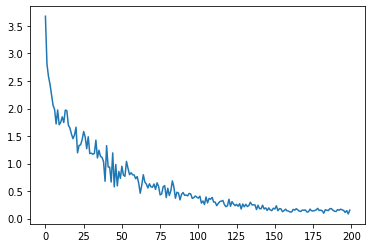

In [11]:
n_epochs = 2000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    #############
    hn, cn = model.init_hidden()
    #############
    # Load text
    inputs, targets = random_training_set()
    if inputs.size()[0] < 200: continue
    inputs = inputs.cuda()
    targets = targets.cuda()
    # Clear gradients w.r.t. parameters
    #############
    model.zero_grad()
    optimizer.zero_grad()
    #############
    # Forward pass
    loss = 0
    #############
    for i in range(chunk_len-1):
        x = inputs[i]
        target = targets[i].unsqueeze(0).type(torch.LongTensor).cuda()
 
        pred, hn, cn = model(x, hn, cn)
        pred = torch.squeeze(pred, 0)
        loss += criterion(pred, target)
    #############
    # Backward pass
    #############
    loss.backward()
    #############
    # Updating parameters
    #############
    optimizer.step()
    #############
    loss_avg += loss.item() / chunk_len

    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

#################################################
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)

[2] [CS 231n](http://cs231n.stanford.edu/syllabus.html)(http://cs231n.stanford.edu/syllabus.html)

주관적으로 느끼기에 epoch가 400-500 번째부터 문장을 읽기가 수월하였기에, 모델이 다음 단어를 잘 예측하는 것을 확인할 수 있다.
plot에서 약 1500 번째이후 수렴을 하는 것을 볼 수 있는데, 아래 1000 epoch의 train을 더 진행한 결과 모델의 성능이 더 올라가지 않는 것을 확인하였다.

RNN과 LSTM모두 2000년대 이전의 모델로, 상대적으로 최근에 연구된 딥러닝을 기반으로한 Language model의 성능과 활용도가 매우 기대되는 실험였다.




+)
모델에 주석으로 처리된 # i, f, o, g = gates.chunk(4, dim=2) 부분으로 동작하였을 때 train의 evaluation에서 error가 발생하였는데 이유를 아신다면 피드백 남겨주시면 감사합니다!!


************************* epoch100 *************************
loss 7.0742
It go is my life and these times are so hard
And it's getting even harder tryin' to feed and water myy 

************************* epoch200 *************************
loss 22.0119
I cant to say in one spot, another jam or not
Has gotten me to the point, I'm like a snail I've got
TT 

************************* epoch300 *************************
loss 20.0738
I loked on his mouth, but the words won't come out
He's chokin', how, everybody's jokin' now
The clocc 

************************* epoch400 *************************
loss 46.4518
I't buy diapers
And its no movie, there's no Mekhi Phifer
This is my life and these times are so hardd 

************************* epoch500 *************************
loss 22.8574
I's cold water
His hoes don't want him no mo, he's cold product
They moved on to the next schmo who ff 

************************* epoch600 *************************
loss 17.4883
I's cold product
They moved on t

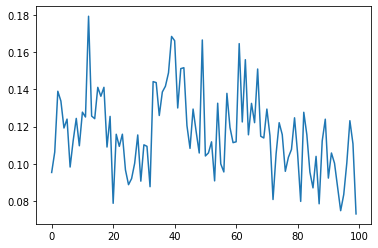

In [12]:
n_epochs = 1000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    #############
    hn, cn = model.init_hidden()
    #############
    # Load text
    inputs, targets = random_training_set()
    if inputs.size()[0] < 200: continue
    inputs = inputs.cuda()
    targets = targets.cuda()
    # Clear gradients w.r.t. parameters
    #############
    model.zero_grad()
    optimizer.zero_grad()
    #############
    # Forward pass
    loss = 0
    #############
    for i in range(chunk_len-1):
        x = inputs[i]
        target = targets[i].unsqueeze(0).type(torch.LongTensor).cuda()
 
        pred, hn, cn = model(x, hn, cn)
        pred = torch.squeeze(pred, 0)
        loss += criterion(pred, target)
    #############
    # Backward pass
    #############
    loss.backward()
    #############
    # Updating parameters
    #############
    optimizer.step()
    #############
    loss_avg += loss.item() / chunk_len

    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

#################################################
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)